# Transformer with Diffrence ID Dataset

In [1]:
from datetime import datetime
import json
import math
import os
import sys
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import (TransformerDecoder, TransformerDecoderLayer,
                      TransformerEncoder, TransformerEncoderLayer)
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
try:
  from google.colab import drive
  IS_GOOGLE_COLAB = True
except ImportError:
  IS_GOOGLE_COLAB = False

if IS_GOOGLE_COLAB:
  mount_path = '/content/drive'
  base_folder = os.path.join(mount_path, "My Drive", "Data")
  data_folder = os.path.join(base_folder, "FX")
else:
  base_folder = 'L:/data'
  data_folder = os.path.join(base_folder, "fx", "OANDA-Japan MT5 Live")


device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [ ]:
model_name = "ohlc_did_transformer"
model_version = "1"

# parameters for dataset
ohlc_column = ['open','high','low','close']
time_column = "time"
file_name = "mt5_USDJPY_min30.csv"
file_path = os.path.join(data_folder, file_name)
file_path = os.path.abspath(file_path)

# training parameters
observation_length = 60
prediction_length = 10
lr = 0.0001
batch_size = 64

# model parameters
model_params = {
    "nhead": 4,
    "d_model": 120,
    "dim_feedforward": 10,
    "num_encoder_layers": 4,
    "num_decoder_layers": 4,
    # replace after dataset is defined
    "ohlc_size": None,
    "dropout": 0.1
}

In [3]:
import os
import shutil
import sys
import zipfile
import requests

def download_modlue_from_gh(repository, github_account='Naradice', branch='master', folder=None, module_path='/gdrive/My Drive/modules', **kwargs):
  if folder is None:
    folder = repository
  print(f"Downloading {repository} from {github_account}/{repository}/{branch}...")

  zip_url = f"https://github.com/{github_account}/{repository}/archive/refs/heads/{branch}.zip"
  response = requests.get(zip_url)
  if response.status_code == 200:
    with open("temp.zip", "wb") as f:
      f.write(response.content)
    with zipfile.ZipFile("temp.zip", "r") as zip_ref:
      zip_ref.extractall("temp_dir")

    if isinstance(folder, str):
      folders = [folder]
    else:
      folders = folder
    for folder in folders:    
      source_folder = f"temp_dir/{repository}-{branch}/{folder}"
      destination_folder = os.path.join(module_path, folder)
      print(f"Copying {source_folder} to {destination_folder}...")
      shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)
    os.remove("temp.zip")
    shutil.rmtree("temp_dir")
  else:
    print(f"filed to download {zip_url}: {response.status_code}, {response.text}")

In [4]:
if IS_GOOGLE_COLAB:
  drive.mount(mount_path)
  module_path = f"{mount_path}/My Drive/modules"
else:
  module_path = '../../modules'

if os.path.exists(module_path) is False:
  os.makedirs(module_path)

repositories = [
    {'repository': 'stocknet_study', 'branch': 'master', 'folder': ['Dataset', 'SN_Utils'], 'refresh': False},
    {'repository': 'finance_process', 'branch': 'master', 'folder': 'fprocess', 'refresh': False},
    {'repository': 'cloud_storage_handler', 'branch': 'main', 'folder': 'cloud_storage_handler', 'refresh': False},
]

destination = os.path.join(module_path, '__init__.py')
if os.path.exists(destination) is False:
  with open(destination, mode='w') as fp:
    fp.close()

for repo_kwargs in repositories:
  folders = repo_kwargs['folder']
  if isinstance(folders, str):
    folders = [folders]
  is_missing = False
  for folder in folders:
    destination = os.path.join(module_path, folder)
    if repo_kwargs['refresh'] or os.path.exists(destination) is False:
      is_missing = True
      break
  if is_missing:
    download_modlue_from_gh(**repo_kwargs, module_path=module_path)

In [5]:
sys.path.append(module_path)

import fprocess
import Dataset
import cloud_storage_handler
import SN_Utils

In [6]:
# Initialize cloud storage handler if needed
from cloud_storage_handler import DropboxHandler


# storage_handler = DropboxHandler("nhjrq1cjpugk5hc", "http://localhost")
# storage_handler.authenticate()
# Otherwise, specify None
storage_handler = None

## Define Dataset

In [20]:
import random
from collections.abc import Iterable

import numpy as np
import torch


class CloseDiffIDDS:
    
    def __init__(self, df, ohlc_columns, volume_column=None, spread_column=None, observation_length=60, decimal_digits=3,
                device="cuda", future_step_size=1, seed=1017, is_training = True, with_close=True, clip_range=None):
        self.seed(seed)
        self._BIAS = 10
        self.columns = ohlc_columns
        self.decimal_digits = decimal_digits
        self.__length_difference = 0
        self.__with_close = with_close
        self.__clip_range = clip_range
        self.__data = df.copy()
        self.ohlc_idf = self.__init_ohlc(df, ohlc_columns, decimal_digits=decimal_digits, with_close=with_close, clip_range=clip_range)
        
        self.observation_length = observation_length
        self.device = device
        self.future_step_size = future_step_size
        self.is_training = is_training
        self.__init_indicies(self.ohlc_idf)
    
    def __init_indicies(self, data, split_ratio=0.8):
        length = len(data) - self.observation_length - self.future_step_size
        if length < 0:
            raise Exception(f"date length {length} is less than observation_length {self.observation_length}")
        
        to_index = int(length * split_ratio)
        from_index = 0
        train_indices = list(range(from_index, to_index))
        self.train_indices = random.sample(train_indices, k=to_index - from_index)

        # Note: If unique value exits in validation data only, validation loss would be grater than expected
        from_index = int(length * split_ratio) + self.observation_length + self.future_step_size
        to_index = length
        eval_indices = list(range(from_index, to_index))
        self.eval_indices = random.sample(eval_indices, k=to_index - from_index)
        
        if self.is_training:
            self._indices = self.train_indices
        else:
            self._indices = self.eval_indices
    
    def __init_ohlc(self, df, ohlc_columns, decimal_digits = 3, with_close=True, clip_range=None):
        if with_close:
            close_column = [ohlc_columns[3]]
            ohlc_cls_diff_df = df[ohlc_columns].iloc[1:] - df[close_column].iloc[:-1].values
            self.__length_difference += 1
        else:
            ohlc_cls_diff_df = df[ohlc_columns].diff().dropna()
            self.__length_difference += 1
        if clip_range is not None:
            ohlc_cls_diff_df = ohlc_cls_diff_df.clip(lower=clip_range[0], upper=clip_range[1])
        min_value = ohlc_cls_diff_df.min().min()
        min_value_abs = abs(min_value)

        self.__scale = 10 ** decimal_digits
        lower_value = math.ceil(min_value_abs) * self.__scale
        upper_value = math.ceil(ohlc_cls_diff_df.max().max()) * self.__scale
        self.ohlc_lower = lower_value
        id_df =  np.round(ohlc_cls_diff_df * self.__scale) + lower_value
        id_df = id_df.astype('int64')
        # add bias to avoid 0 value in the dataset
        self.ohlc_range_size = lower_value + upper_value + self._BIAS
        return id_df
    
    def revert_diff(self, prediction, index):
        periods = self.__length_difference
        org_indices = self.get_actual_index(index)
        if self.__with_close:
            if type(org_indices) is int:
                target_index = self.get_target_range(org_indices).start - periods
                last_close = self.__data[self.columns[3]].iloc[target_index].values
            else:
                target_index = [self.get_target_range(i).start - periods for i in org_indices]
                batch_size = len(org_indices)
                last_close = self.__data[self.columns[3]].iloc[target_index].values.reshape(batch_size, 1)
            return last_close + prediction
        else:
            if type(org_indices) is int:
                target_index = self.get_target_range(indeorg_indicesx).start - periods
                last_value = self.__data[self.columns].iloc[target_index].values
            else:
                target_index = [self.get_target_range(i).start - periods for i in org_indices]
                batch_size = len(org_indices)
                last_value = self.__data[self.columns].iloc[target_index].values.reshape(batch_size, len(self.columns))
            return prediction + last_value
    
    def revert_target(self, tgt_ohlc, indices):
        if tgt_ohlc.size(1) != len(indices):
            raise Exception("batch_size should be same as indices size")
        batch_size = len(indices)
        #revet id to difference: ohlc - last close
        tgt_values = tgt_ohlc.cpu().detach().numpy()
        scale = np.float64(1 / self.__scale)
        ohlc_diff = (tgt_values - self.ohlc_lower).astype(np.float64) * scale
        first_ohlc = self.revert_diff(ohlc_diff[0], indices)
        if self.__with_close:
            last_value = first_ohlc[:, -1:]
        else:
            last_value = first_ohlc
        revert_ohlc = first_ohlc.reshape(1, batch_size, 4)
        
        # last_observation + future_step_size
        for i in range(1, tgt_ohlc.size(0)):
            next_ohlc = ohlc_diff[i] + last_value
            if self.__with_close:
                last_value = next_ohlc[:, -1:]
            else:
                last_value = next_ohlc
            # print(revert_ohlc.shape, next_ohlc.shape)
            revert_ohlc = np.concatenate([revert_ohlc, next_ohlc.reshape(1, batch_size, 4)], axis=0)
        
        return ohlc_diff, revert_ohlc

    
    def __get_data_set(self, idx):
        ohlc_ids = self.ohlc_idf.iloc[idx].values.tolist()
        return ohlc_ids
    
    def get_target_range(self, index):
        return slice(index + self.observation_length -1, index + self.observation_length + self.future_step_size)

    def _output_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = self.get_target_range(index)
            ohlc_ids = self.__get_data_set(idx)
            ohlc_ids = torch.tensor(ohlc_ids, device=self.device, dtype=torch.int64)
            
            return ohlc_ids
        elif type(batch_size) == slice:    
            ohlc_chunk_data = []            
            for index in self._indices[batch_size]:
                idx = self.get_target_range(index)
                ohlc_ids = self.__get_data_set(idx)
                
                ohlc_chunk_data.append(ohlc_ids)
                
            ohlc_ids = torch.tensor(ohlc_chunk_data, device=self.device, dtype=torch.int64).transpose(0, 1)
            return ohlc_ids
    
    def get_observation_range(self, index):
        return slice(index, index + self.observation_length)
    
    def _input_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = self.get_observation_range(index)
            ohlc_ids = self.__get_data_set(idx)
            ohlc_ids = torch.tensor(ohlc_ids, device=self.device, dtype=torch.int64)

            return ohlc_ids
        elif type(batch_size) == slice:
            ohlc_chunk_data = []
            
            for index in self._indices[batch_size]:
                idx = self.get_observation_range(index)
                ohlc_ids = self.__get_data_set(idx)
                
                ohlc_chunk_data.append(ohlc_ids)
                
            ohlc_ids = torch.tensor(ohlc_chunk_data, device=self.device, dtype=torch.int64).transpose(0, 1)
            return ohlc_ids
    
    def __len__(self):
        return len(self._indices)
    
    def __getitem__(self, ndx):
        return self._input_func(ndx), self._output_func(ndx)
    
    def seed(self, seed=None):
        '''
        '''
        if seed is None:
            seed = 1192
        else:
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)
        self.seed_value = seed
            
    def eval(self):
        self._indices = self.eval_indices
        self.is_training = False
        
    def train(self):
        self._indices = self.train_indices
        self.is_training = False
    
    def get_index_range(self):
        return min(self._indices), max(self._indices)

    def get_date_range(self):
        min_index, max_index = self.get_index_range()
        return self.__data.index[min_index + self.__length_difference], self.__data.index[max_index + self.__length_difference]
    
    def get_actual_index(self, ndx):
        inputs = []
        if type(ndx) == slice:
            inputs = [index + self.__length_difference for index in self._indices[ndx]]
        elif isinstance(ndx, Iterable):
            for index in ndx:
                inputs.append(self._indices[index] + self.__length_difference)
        else:
            return self._indices[ndx] + self.__length_difference
        return inputs

## Define Model

input diff with positional encoding

output ohlc values with softmax

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000, dropout=0.05):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        #pe = pe.unsqueeze(0)
        #pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, src, tgt):
        src_pos = src.size(1)
        tgt_pos = src_pos + tgt.size(1) - 1
        return self.dropout(src + self.pe[:src_pos, :]), self.dropout(tgt + self.pe[src_pos-1:tgt_pos, :])

In [9]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(Perceptron, self).__init__()

        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())

        for i in range(num_layers-2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_dim, output_dim))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        out = self.layers(x)
        return out

In [10]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        d_model: int, ohlc_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()
        
        d_model = d_model + (d_model % 4)
        emb_d_model = int(d_model/4)
        self.ohlc_embedded_layer = torch.nn.Embedding(num_embeddings=ohlc_size, embedding_dim = emb_d_model)
        
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        self.open_output = Perceptron(d_model, ohlc_size, ohlc_size, 4)
        self.high_output = Perceptron(d_model, ohlc_size, ohlc_size, 4)
        self.low_output = Perceptron(d_model, ohlc_size, ohlc_size, 4)
        self.close_output = Perceptron(d_model, ohlc_size, ohlc_size, 4)
        self.activation = nn.Softmax(dim=2)
        

    def forward(
        self, src_ohlc: Tensor, tgt_ohlc: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        src = self.ohlc_embedded_layer(src_ohlc)
        src = src.reshape(src.size(0), src.size(1), src.size(2)*src.size(3))
        
        tgt = self.ohlc_embedded_layer(tgt_ohlc)
        tgt = tgt.reshape(tgt.size(0), tgt.size(1), tgt.size(2)*tgt.size(3))
        
        src, tgt = self.positional_encoding(src, tgt)
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        open = self.activation(self.open_output(outs))
        high = self.activation(self.high_output(outs))
        low = self.activation(self.low_output(outs))
        close = self.activation(self.close_output(outs))
        
        return open, high, low, close

In [11]:
def train(model, ds, optimizers, criterion, batch_size):
    
    model = model.train()
    ds.train()
    losses = [0, 0, 0, 0]
    
    end_index = len(ds) - batch_size
    
    count = 0
    for index in tqdm(range(0, end_index, batch_size)):
        count += 1
        ohlc_src, ohlc_tgt = ds[index:index+batch_size]        
        in_ohlc_tgt = ohlc_tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_ohlc_tgt.size(0)).to(device)
        logits_o, logits_h, logits_l, logits_c  = model(
            src_ohlc=ohlc_src, tgt_ohlc=in_ohlc_tgt,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )

        out_ohlc_tgt = ohlc_tgt[1:, :]
        #print(logits_o.shape, out_ohlc_tgt.shape)
        out_o_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 0].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_h_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 1].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_l_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 2].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_c_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 3].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        
        #print(logits_o.shape, out_o_tgt.shape)
        #print(logits_v.shape, out_v_tgt.shape)
        for optimizer in optimizers:
            optimizer.zero_grad()
        
        o_loss = criterion(logits_o, out_o_tgt)
        h_loss = criterion(logits_h, out_h_tgt)
        l_loss = criterion(logits_l, out_l_tgt)
        c_loss = criterion(logits_c, out_c_tgt)
        loss = (o_loss + h_loss + l_loss + c_loss)/4
        
        loss.backward()
        for optimizer in optimizers:
            optimizer.step()
            
        losses[0] += o_loss.item()
        losses[1] += h_loss.item()
        losses[2] += l_loss.item()
        losses[3] += c_loss.item()
    
    losses = [loss/end_index for loss in losses]
    return losses

In [12]:
def evaluate(model, ds, criterion, batch_size):
    
    model = model.eval()
    ds.eval()
    losses = [0, 0, 0, 0]
    end_index = len(ds) - batch_size
    count = 0
    for index in range(0, end_index, batch_size):
        count += 1
        ohlc_src, ohlc_tgt = ds[index:index+batch_size]
        in_ohlc_tgt = ohlc_tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_ohlc_tgt.size(0)).to(device)
        logits_o, logits_h, logits_l, logits_c  = model(
            src_ohlc=ohlc_src, tgt_ohlc=in_ohlc_tgt,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )

        out_ohlc_tgt = ohlc_tgt[1:, :]
        #print(logits_o.shape, out_ohlc_tgt.shape)
        out_o_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 0].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_h_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 1].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_l_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 2].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_c_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 3].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        
        o_loss = criterion(logits_o, out_o_tgt)
        h_loss = criterion(logits_h, out_h_tgt)
        l_loss = criterion(logits_l, out_l_tgt)
        c_loss = criterion(logits_c, out_c_tgt)
        
        losses[0] += o_loss.item()
        losses[1] += h_loss.item()
        losses[2] += l_loss.item()
        losses[3] += c_loss.item()
    
    losses = [loss/end_index for loss in losses]
    return losses

## Training

In [ ]:
df = pd.read_csv(file_path, parse_dates=[time_column], index_col=0)
ds = CloseDiffIDDS(df, ohlc_column, observation_length=observation_length,
                device=device, future_step_size=prediction_length, seed=1017, is_training = True, with_close=False, clip_range=(-2, 2))
model_params['ohlc_size'] = ds.ohlc_range_size

In [ ]:
model = Seq2SeqTransformer(
    **model_params
)

params_num = 0
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
    if p.requires_grad:
        params_num += p.numel()
print(f"params: {params_num}")

model = model.to(device)
criterion = nn.CrossEntropyLoss()

params: 195792460


In [34]:
logger = SN_Utils.Logger(
    version=model_version,
    model_name=model_name,
    storage_handler=storage_handler
)

In [35]:
start_index, end_index = ds.get_date_range()
params = {"processes": None,
          "source": {
              "path": file_path,
              "start": start_index.isoformat(),
              "end": end_index.isoformat(),
              "length": len(ds)
          },
          "features": ohlc_column,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          **model_params,
          "params_num": params_num,
          # format version
          "version": 2
}

logger.save_params(params, model_name, model_version)

print("training log will be saved on ", logger.log_file_path)

training log will be saved on  ./ohlc_did_transformer\ohlc_did_transformer_v1.csv


In [36]:
def get_parameters(model, outlayer_name, limit_outlayer=False):
    parameters = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            if "output" in name:
                if outlayer_name in name:
                    parameters.append(param)
            elif limit_outlayer is False:
                parameters.append(param)
                
    return parameters

In [37]:
optimizer_o = torch.optim.AdamW(get_parameters(model, "open_output"), lr=lr)
scheduler_o = torch.optim.lr_scheduler.StepLR(optimizer_o, 1.0, gamma = 0.1)
optimizer_h = torch.optim.AdamW(get_parameters(model, "high_output"), lr=lr)
scheduler_h = torch.optim.lr_scheduler.StepLR(optimizer_h, 1.0, gamma = 0.1)
optimizer_l = torch.optim.AdamW(get_parameters(model, "low_output"), lr=lr)
scheduler_l = torch.optim.lr_scheduler.StepLR(optimizer_l, 1.0, gamma = 0.1)
optimizer_c = torch.optim.AdamW(get_parameters(model, "close_output"), lr=lr)
scheduler_c = torch.optim.lr_scheduler.StepLR(optimizer_c, 1.0, gamma = 0.1)

In [39]:
epoch = 5
model.train()
ds.train()
best_loss = float('Inf')
best_model = None
best_losses = [float('Inf') for i in range(6)]
patience = 3
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizers=[optimizer_o, optimizer_h, optimizer_l, optimizer_c],
        criterion=criterion, batch_size=batch_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size
    )
    
    mean_loss_train = np.mean(loss_train)
    mean_loss_valid = np.mean(loss_valid)
    print(f'{loop}/{epoch} {str(int(math.floor(elapsed_time / 60))) + "m" if math.floor(elapsed_time / 60) > 0 else ""}{elapsed_time % 60}s count: {counter}, \
        {mean_loss_train}, {mean_loss_valid}\
        {"**" if best_loss > mean_loss_valid else ""}')
    print(f'train loss: {loss_train}')
    print(f'valid loss: {loss_valid}')
    logger.add_training_log(mean_loss_train, mean_loss_valid, log_entry=[*loss_train, *loss_valid, elapsed_time])
    
    if best_loss > mean_loss_valid:
        best_loss = mean_loss_valid
        best_model = model
        counter = 0
        logger.save_model(best_model)
    else:
        counter += 1
    for index, scheduler in enumerate([scheduler_o, scheduler_h, scheduler_l, scheduler_c]):
        if best_losses[index] < loss_valid[index]:
            scheduler.step()
        
    if counter > patience:
        break

100%|██████████| 1258/1258 [1:18:52<00:00,  3.76s/it]


1/5 78m52.12064862251282s count: 0,         0.0010378627417123264, 0.001038995168370607        **
train loss: [0.001037862735044726, 0.0010378627386563428, 0.0010378627472686602, 0.0010378627458795767]
valid loss: [0.0010389951721897935, 0.0010389951632473083, 0.0010389951729350005, 0.001038995165110326]


100%|██████████| 1258/1258 [1:17:15<00:00,  3.69s/it]


2/5 77m15.801884889602661s count: 0,         0.001037862721014983, 0.0010389951647377224        **
train loss: [0.001037862721616919, 0.0010378627158753742, 0.0010378627272658585, 0.00103786271930178]
valid loss: [0.0010389951602664798, 0.0010389951598938762, 0.0010389951751706217, 0.0010389951636199117]


100%|██████████| 1258/1258 [1:10:22<00:00,  3.36s/it]


3/5 70m22.294677734375s count: 0,         0.0010378626965902656, 0.0010389951560746897        **
train loss: [0.0010378626917053222, 0.0010378626967986282, 0.0010378627039292565, 0.0010378626939278558]
valid loss: [0.0010389951535596158, 0.0010389951550500301, 0.0010389951628747046, 0.0010389951528144087]


100%|██████████| 1258/1258 [1:09:49<00:00,  3.33s/it]


4/5 69m49.635018825531006s count: 0,         0.0010378626612612433, 0.001038995146945903        **
train loss: [0.0010378626541074634, 0.0010378626691095647, 0.001037862663923653, 0.0010378626579042917]
valid loss: [0.0010389951464801483, 0.0010389951524418053, 0.0010389951505787875, 0.0010389951382828702]


100%|██████████| 1258/1258 [1:09:36<00:00,  3.32s/it]


5/5 69m36.53442597389221s count: 0,         0.0010378626235013249, 0.001038995142008906        **
train loss: [0.001037862617713477, 0.0010378626266962167, 0.0010378626295669891, 0.0010378626200286162]
valid loss: [0.0010389951297129886, 0.0010389951446171306, 0.0010389951498335805, 0.0010389951438719235]


## Evaluation

In [40]:
# Define prediction functions

def calculate_joint(tensor_a, tensor_b, beam_width=10):
    joint_array = []
    for i in range(beam_width):
        joint_array.append(torch.mul(tensor_a[:, :, i:i+1], tensor_b))
    joint_tensor = torch.concat(joint_array, dim=2)
    return joint_tensor

def next_preds_beam(scores_array, indices_array, batch_size=16, beam_width=10):
    beam_batch = batch_size * beam_width
    joint_indices_array = []
    joint_score = scores_array[0]

    for logits in scores_array[1:]:
        joint_score = calculate_joint(joint_score, logits, beam_width=beam_width)
        joint_score, joint_indices = torch.topk(joint_score, k=beam_width, dim=-1)
        joint_indices_array.append(joint_indices)
    
    next_preds_array = []
    indices_array.reverse()
    for index, indices in enumerate(indices_array[:-1]):
        joint_indices = joint_indices_array[index]
        target_indices = torch.remainder(joint_indices, beam_width)
        next_preds = indices.gather(dim=-1, index=target_indices)
        next_preds_array.append(next_preds.mT.reshape(1, beam_batch, 1))
        
    target_indices = joint_indices // beam_width
    next_preds = indices_array[-1].gather(dim=-1, index=target_indices)
    next_preds_array.append(next_preds.mT.reshape(1, beam_batch, 1))
    next_preds_array.reverse()
    
    next_ohlc_preds = torch.concat(next_preds_array, dim=-1)
    
    return next_ohlc_preds

def joint_beam_search(model, input_data, beam_width, max_len, max_range=None):
    if max_range is None:
        max_id_index = None
    else:
        max_id_index = max_range - 1
    ohlc_src = input_data
    batch_size = ohlc_src.shape[1]
    preds_ohlc = ohlc_src[-1:, :, :]
    mask_tgt = nn.Transformer.generate_square_subsequent_mask(preds_ohlc.size(0)).to(device)
    
    logits_o, logits_h,logits_l,logits_c  = model(
        src_ohlc=ohlc_src, tgt_ohlc=preds_ohlc,
        mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
        memory_key_padding_mask=None
    )
    
    scores_o, indices = torch.topk(logits_o, k=beam_width, dim=-1)
    scores_h, indices_h = torch.topk(logits_h, k=beam_width, dim=-1)
    scores_l, indices_l = torch.topk(logits_l, k=beam_width, dim=-1)
    scores_c, indices_c = torch.topk(logits_c, k=beam_width, dim=-1)
    
    next_ohlc_preds = next_preds_beam(
        scores_array=[scores_o, scores_h, scores_l, scores_c],
        indices_array=[indices, indices_h, indices_l, indices_c],
        batch_size=batch_size, beam_width=beam_width
    )
    
    preds_ohlc = preds_ohlc.repeat(1, beam_width, 1)
    ohlc_src = ohlc_src.repeat(1, beam_width, 1)
    
    for t in range(1, max_len):
        preds_ohlc = torch.concat([preds_ohlc, next_ohlc_preds], dim=0)

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(preds_ohlc.size(0)).to(device)
        logits_o, logits_h, logits_l,logits_c = model(
            src_ohlc=ohlc_src, tgt_ohlc=preds_ohlc, mask_tgt=mask_tgt, 
            mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )
        
        beamed_feature_size = logits_o.shape[2]*beam_width

        scores_o, indices_o = torch.topk(logits_o[-1:].reshape(1, batch_size, beamed_feature_size), k=beam_width, dim=-1)
        indices_o = torch.remainder(indices_o, beamed_feature_size)
        scores_h, indices_h = torch.topk(logits_h[-1:].reshape(1, batch_size, beamed_feature_size), k=beam_width, dim=-1)
        indices_h = torch.remainder(indices_h, beamed_feature_size)
        scores_l, indices_l = torch.topk(logits_l[-1:].reshape(1, batch_size, beamed_feature_size), k=beam_width, dim=-1)
        indices_l = torch.remainder(indices_l, beamed_feature_size)
        scores_c, indices_c = torch.topk(logits_c[-1:].reshape(1, batch_size, beamed_feature_size), k=beam_width, dim=-1)
        indices_c = torch.remainder(indices_c, beamed_feature_size)
        
        next_ohlc_preds = next_preds_beam(
            scores_array=[scores_o, scores_h, scores_l, scores_c],
            indices_array=[indices, indices_h, indices_l, indices_c],
            batch_size=batch_size, beam_width=beam_width
        )

        if max_id_index is not None:
            next_ohlc_preds = torch.clamp(next_ohlc_preds, min=0, max=max_id_index)
    
    preds_ohlc = torch.concat([preds_ohlc, next_ohlc_preds], dim=0)
        
    return preds_ohlc

### Check revert and prediction process

In [41]:
sample_index = 0
ds.eval()

input_data, tgt_data = ds[sample_index:sample_index+2]

In [42]:
# tgt_length, batch_size, feature_size = tgt_data.shape
tgt_data[:, 0]

tensor([[1979, 1973, 1821, 1825],
        [1828, 1989, 2000, 2162],
        [2170, 2004, 2166, 1995],
        [1983, 2027, 1999, 2041],
        [2041, 2017, 2031, 1999],
        [2000, 2027, 2008, 2035],
        [2035, 2019, 2002, 1989],
        [1989, 2054, 2011, 2084],
        [2084, 2026, 2053, 1988],
        [1988, 1976, 1975, 1946],
        [1946, 1920, 1946, 1981]])

In [43]:
# check sample_tgt_indices are valid
sample_tgt_indices = ds.get_target_range(ds._indices[sample_index])
id_df = ds.ohlc_idf.iloc[sample_tgt_indices]
id_df

,open,high,low,close
time,,,,
2021-07-08 23:30:00,1979,1973,1821,1825
2021-07-09 00:00:00,1828,1989,2000,2162
2021-07-09 00:30:00,2170,2004,2166,1995
2021-07-09 01:00:00,1983,2027,1999,2041
2021-07-09 01:30:00,2041,2017,2031,1999
2021-07-09 02:00:00,2000,2027,2008,2035
2021-07-09 02:30:00,2035,2019,2002,1989
2021-07-09 03:00:00,1989,2054,2011,2084
2021-07-09 03:30:00,2084,2026,2053,1988


In [44]:
# check original values and indices
index_org = ds.get_actual_index(sample_index)
sample_tgt_indices_org = ds.get_target_range(index_org)
tgt_org = df[ohlc_column].iloc[sample_tgt_indices_org]

# print original values
print("Original values: Target")
print(tgt_org)

Original values: Target
                        open     high      low    close
time                                                   
2021-07-08 23:30:00  109.756  109.761  109.570  109.581
2021-07-09 00:00:00  109.584  109.750  109.570  109.743
2021-07-09 00:30:00  109.754  109.754  109.736  109.738
2021-07-09 01:00:00  109.737  109.781  109.735  109.779
2021-07-09 01:30:00  109.778  109.798  109.766  109.778
2021-07-09 02:00:00  109.778  109.825  109.774  109.813
2021-07-09 02:30:00  109.813  109.844  109.776  109.802
2021-07-09 03:00:00  109.802  109.898  109.787  109.886
2021-07-09 03:30:00  109.886  109.924  109.840  109.874
2021-07-09 04:00:00  109.874  109.900  109.815  109.820
2021-07-09 04:30:00  109.820  109.820  109.761  109.801


In [45]:
# caliculate revert values with dataset output
id_to_diff_tgt, reverted_tgt = ds.revert_target(tgt_data[:, sample_index:sample_index+1, :], [sample_index])

In [46]:
# check if id process have errors
org_diff_tgt = df[ohlc_column].diff().iloc[sample_tgt_indices_org].values.reshape(*id_to_diff_tgt.shape)
np.allclose(id_to_diff_tgt, org_diff_tgt, atol=1e-10)

True

In [47]:
# check if revert process have errors
org_tgt = df[ohlc_column].iloc[sample_tgt_indices_org].values.reshape(*reverted_tgt.shape)
np.allclose(reverted_tgt, org_tgt, atol=1e-10)

True

In [48]:
# caliculate predictions with model
model = model.eval()
preds_ohlc = joint_beam_search(model, input_data, beam_width=3, max_len=10, max_range=ds.ohlc_range_size)

In [49]:
# show first candidate
preds_ohlc[1:, 0]

tensor([[ 888, 1610, 1985, 1993],
        [ 888, 4009, 4009, 1993],
        [ 888, 4009, 4009, 1993],
        [ 888, 4009, 4009, 1993],
        [ 888, 4009, 4009, 1993],
        [ 888, 4009, 4009, 1993],
        [ 888, 4009, 4009, 1993],
        [ 888, 4009, 1752, 1993],
        [ 888, 4009, 4009, 1993],
        [ 888, 4009, 1752, 1993]])

In [50]:
# revert predictions to original values
preds_diff, preds_rev = ds.revert_target(preds_ohlc[:, 0:1], [sample_index])
preds_diff[:, 0]

array([[-0.021, -0.027, -0.179, -0.175],
       [-1.112, -0.39 , -0.015, -0.007],
       [-1.112,  2.009,  2.009, -0.007],
       [-1.112,  2.009,  2.009, -0.007],
       [-1.112,  2.009,  2.009, -0.007],
       [-1.112,  2.009,  2.009, -0.007],
       [-1.112,  2.009,  2.009, -0.007],
       [-1.112,  2.009,  2.009, -0.007],
       [-1.112,  2.009, -0.248, -0.007],
       [-1.112,  2.009,  2.009, -0.007],
       [-1.112,  2.009, -0.248, -0.007]])

## Evaluate with validation data

In [51]:
import time

ds.eval()
model = model.eval()

ans_ohlc = None
pre_ohlc = None
pre_ohlc_diff = None

start_time = time.time()
for index in range(0, len(ds), batch_size):
    if len(ds) - index < batch_size:
        ndx = slice(index, len(ds))
        indices = [i for i in range(index, len(ds))]
        B = len(ds) - index
    else:
        ndx = slice(index, index+batch_size)
        indices = [i for i in range(index, index+batch_size)]
        B = batch_size
    val_inp, val_ans = ds[ndx]
            
    preds_ohlc_candidates = joint_beam_search(model, val_inp, beam_width=3, max_len=10, max_range=ds.ohlc_range_size)
    # batch is repeated by beam_width. Retrieve only the first beam_width
    first_pre_ohlc = preds_ohlc_candidates[:, :B, :]
    pre_ohlc_diff_item, pre_ohlc_item = ds.revert_target(first_pre_ohlc, indices)

    if pre_ohlc is None:
        pre_ohlc = pre_ohlc_item
        pre_ohlc_diff = pre_ohlc_diff_item
    else:
        pre_ohlc = np.concatenate([pre_ohlc, pre_ohlc_item], axis=1)
        pre_ohlc_diff = np.concatenate([pre_ohlc_diff, pre_ohlc_diff_item], axis=1)

    ans_ohlc_diff_item, ans_ohlc_item = ds.revert_target(val_ans, indices)
    if ans_ohlc is None:
        ans_ohlc = ans_ohlc_item
    else:
        ans_ohlc = np.concatenate([ans_ohlc, ans_ohlc_item], axis=1)

In [52]:
diff_array = pre_ohlc[1:] - ans_ohlc[1:]
columns = ["open", "high", "low", "close"]
mean_df = pd.DataFrame(np.mean(diff_array, axis=1), columns=columns)
var_df = pd.DataFrame(np.var(diff_array, axis=1), columns=columns)

print(mean_df)
print(var_df)

       open       high       low      close
0 -0.061944  -0.156760 -0.759029   0.259901
1 -0.123888   1.021101  0.276849   1.750578
2 -0.185830   2.210141  1.288679   3.242771
3 -0.247775   3.403227  2.296484   4.731834
4 -0.309712   4.599963  3.300344   6.219251
5 -0.371648   5.800081  4.300182   7.704686
6 -0.433582   7.001938  5.298328   9.188084
7 -0.495521   8.205667  6.297241  10.670007
8 -0.557455   9.410554  7.294274  12.150792
9 -0.619392  10.617027  8.288694  13.629950
        open        high         low      close
0   0.742362    0.568194    0.980164   0.469374
1   2.959325    2.158823    2.747014   1.398835
2   6.651461    6.439281    8.425080   3.957994
3  11.816426   13.425217   18.161153   8.170512
4  18.459127   23.102898   31.984333  14.080385
5  26.576345   35.461833   49.923356  21.695979
6  36.168042   50.502756   71.979719  31.051314
7  47.215398   68.196573   98.113317  42.162016
8  59.756684   88.584839  128.388446  55.054067
9  73.769723  111.616925  162.805026

[]

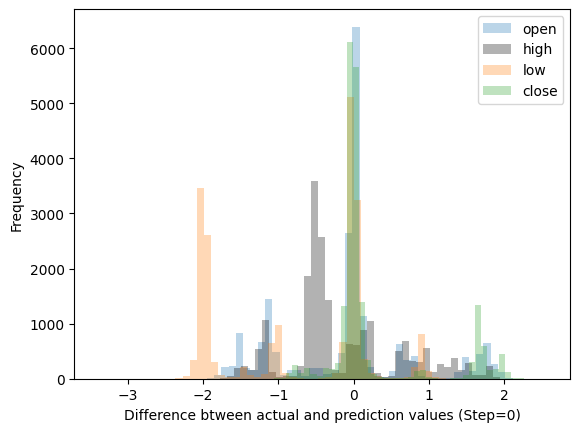

In [53]:
import matplotlib.pyplot as plt

step=0
plt.hist(diff_array[step, :, 0], bins=50, alpha=0.3)
plt.hist(diff_array[step, :, 1], bins=50, alpha=0.3, color="black")
plt.hist(diff_array[step, :, 2], bins=50, alpha=0.3)
plt.hist(diff_array[step, :, 3], bins=50, alpha=0.3)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['open', 'high', "low", "close"])
plt.plot()

[]

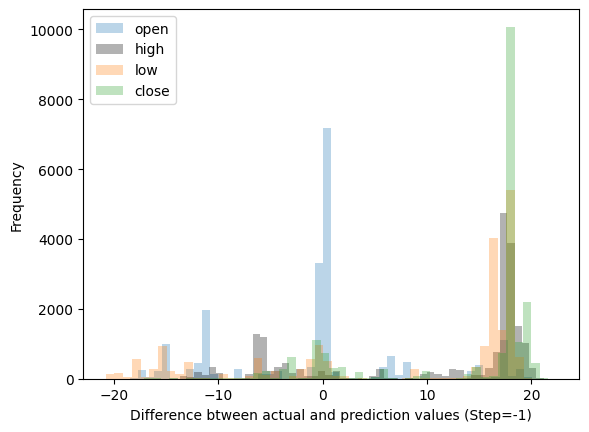

In [54]:
step=-1
plt.hist(diff_array[step, :, 0], bins=50, alpha=0.3)
plt.hist(diff_array[step, :, 1], bins=50, alpha=0.3, color="black")
plt.hist(diff_array[step, :, 2], bins=50, alpha=0.3)
plt.hist(diff_array[step, :, 3], bins=50, alpha=0.3)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['open', 'high', "low", "close"])
plt.plot()

[]

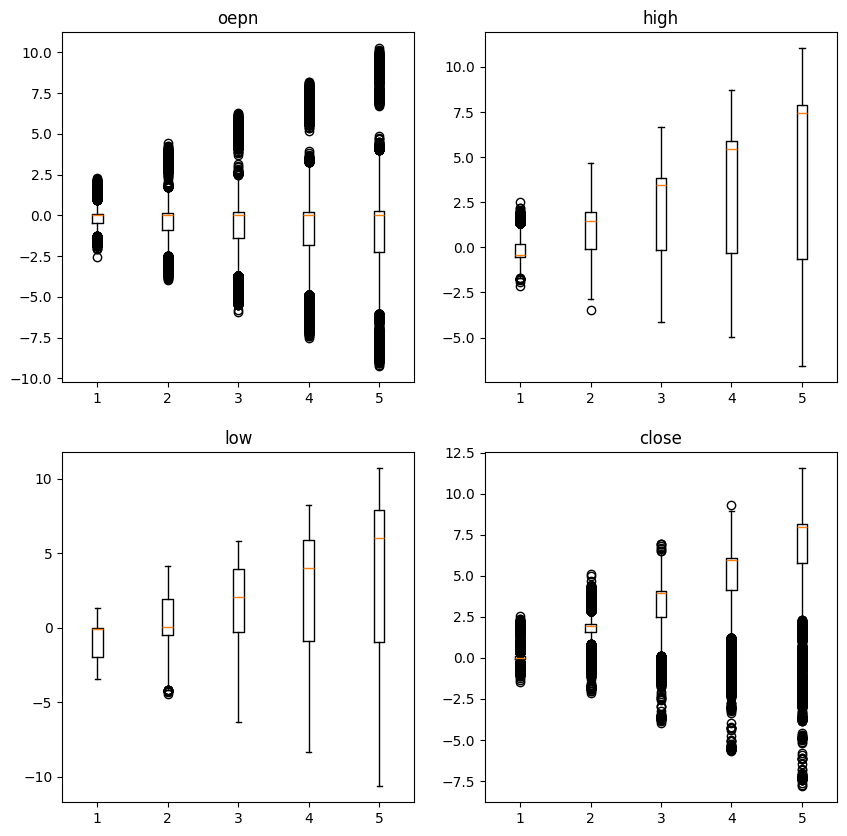

In [55]:
quant_1_df = pd.DataFrame(np.quantile(diff_array, 0.25, axis=1), columns=columns)
quant_2_df = pd.DataFrame(np.quantile(diff_array, 0.5, axis=1), columns=columns)
quant_3_df = pd.DataFrame(np.quantile(diff_array, 0.75, axis=1), columns=columns)
min_df = pd.DataFrame(np.min(diff_array, axis=1), columns=columns)
max_df = pd.DataFrame(np.max(diff_array, axis=1), columns=columns)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# plot quantile values with prediction steps
for index in range(0, 5):
  axs[0,0].boxplot(diff_array[index, :, 0], positions=[index+1])
  axs[0,1].boxplot(diff_array[index, :, 1], positions=[index+1])
  axs[1,0].boxplot(diff_array[index, :, 2], positions=[index+1])
  axs[1,1].boxplot(diff_array[index, :, 3], positions=[index+1])

axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')
plt.plot()

[]

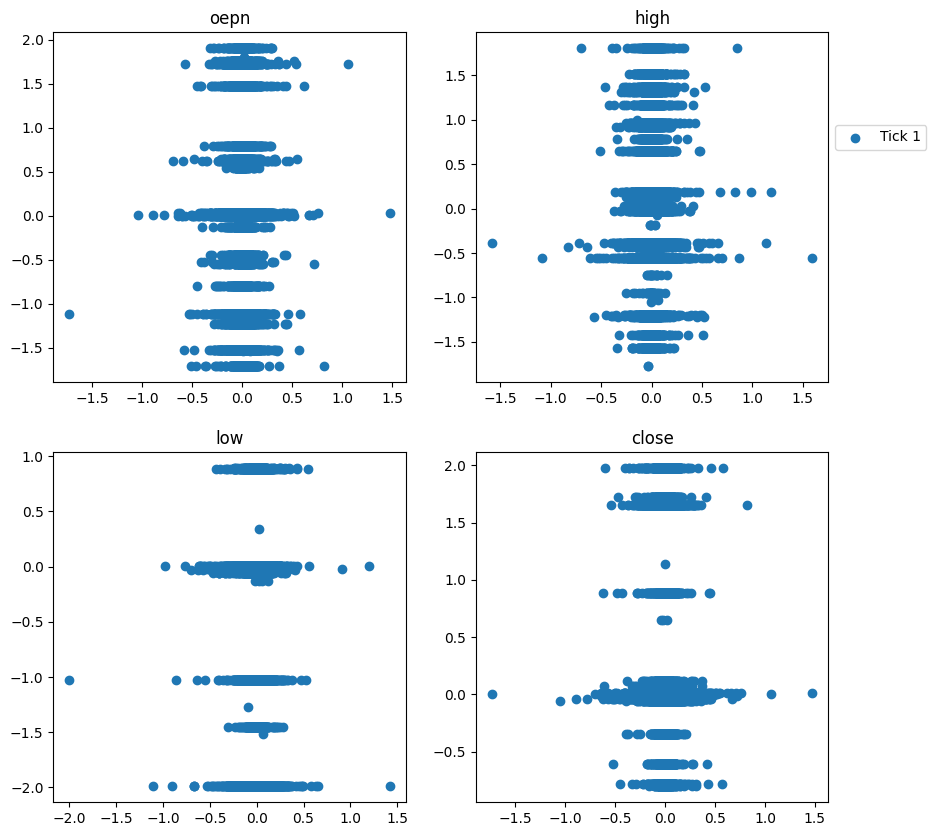

In [56]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

ans_ohlc_diff = np.diff(ans_ohlc, axis=0)
axs[0,0].scatter(ans_ohlc_diff[0, :, 0], pre_ohlc_diff[1, :, 0], label=f'Tick {1}')
axs[0,1].scatter(ans_ohlc_diff[0, :, 1], pre_ohlc_diff[1, :, 1], label=f'Tick {1}')
axs[1,0].scatter(ans_ohlc_diff[0, :, 2], pre_ohlc_diff[1, :, 2], label=f'Tick {1}')
axs[1,1].scatter(ans_ohlc_diff[0, :, 3], pre_ohlc_diff[1, :, 3], label=f'Tick {1}')
axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')

axs[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.plot()

[]

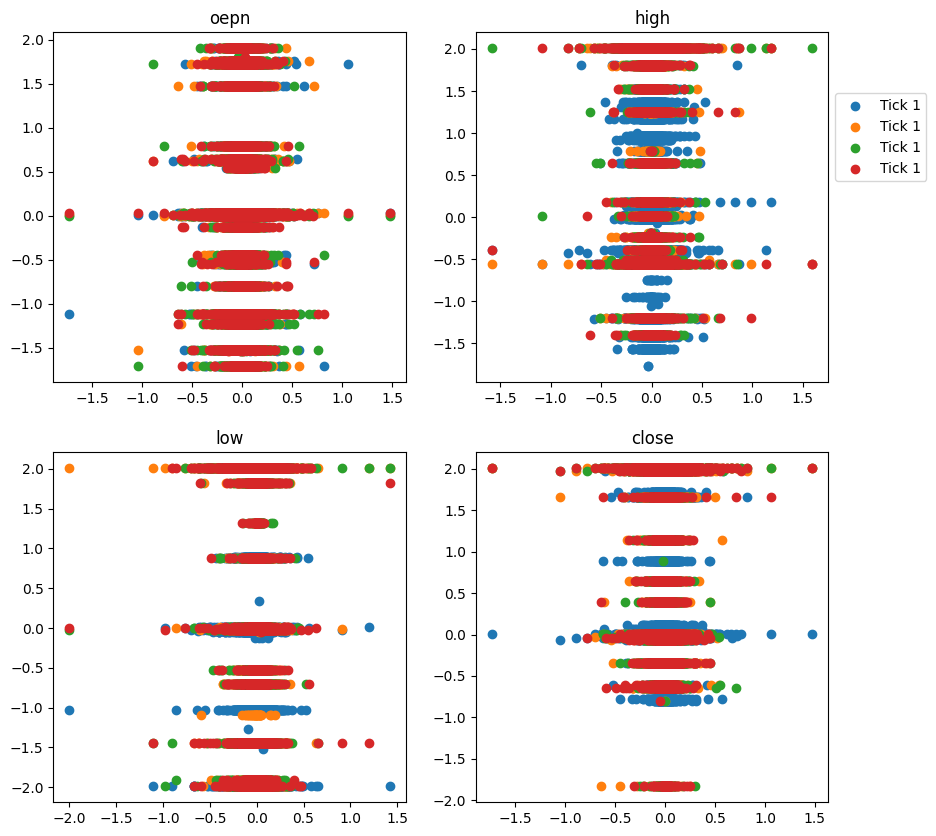

In [57]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for step in range(1, 5):
  axs[0,0].scatter(ans_ohlc_diff[step-1, :, 0], pre_ohlc_diff[step, :, 0], label=f'Tick {1}')
  axs[0,1].scatter(ans_ohlc_diff[step-1, :, 1], pre_ohlc_diff[step, :, 1], label=f'Tick {1}')
  axs[1,0].scatter(ans_ohlc_diff[step-1, :, 2], pre_ohlc_diff[step, :, 2], label=f'Tick {1}')
  axs[1,1].scatter(ans_ohlc_diff[step-1, :, 3], pre_ohlc_diff[step, :, 3], label=f'Tick {1}')
axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')
axs[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.plot()

In [58]:
diff_array_org = pre_ohlc_diff[1:] - ans_ohlc_diff
mean_org_df = pd.DataFrame(np.mean(diff_array_org, axis=1), columns=["open", "high", "low", "close"])
var_org_df = pd.DataFrame(np.var(diff_array_org, axis=1), columns=["open", "high", "low", "close"])

print(mean_org_df)
print(var_org_df)

       open      high       low     close
0 -0.061944 -0.156760 -0.759029  0.259901
1 -0.061943  1.177860  1.035878  1.490676
2 -0.061942  1.189040  1.011830  1.492193
3 -0.061945  1.193087  1.007805  1.489063
4 -0.061938  1.196736  1.003860  1.487417
5 -0.061936  1.200117  0.999838  1.485435
6 -0.061934  1.201857  0.998145  1.483398
7 -0.061939  1.203730  0.998913  1.481922
8 -0.061934  1.204887  0.997034  1.480785
9 -0.061936  1.206474  0.994420  1.479159
       open      high       low     close
0  0.742362  0.568194  0.980164  0.469374
1  0.744099  1.403951  2.052567  0.822081
2  0.744093  1.384946  2.068150  0.824633
3  0.743603  1.377278  2.078063  0.832558
4  0.744330  1.370785  2.086496  0.846094
5  0.744194  1.368333  2.092264  0.853769
6  0.744084  1.364380  2.092631  0.863286
7  0.741678  1.359353  2.090790  0.871315
8  0.744342  1.360078  2.095766  0.879650
9  0.743964  1.356348  2.099885  0.888495


[]

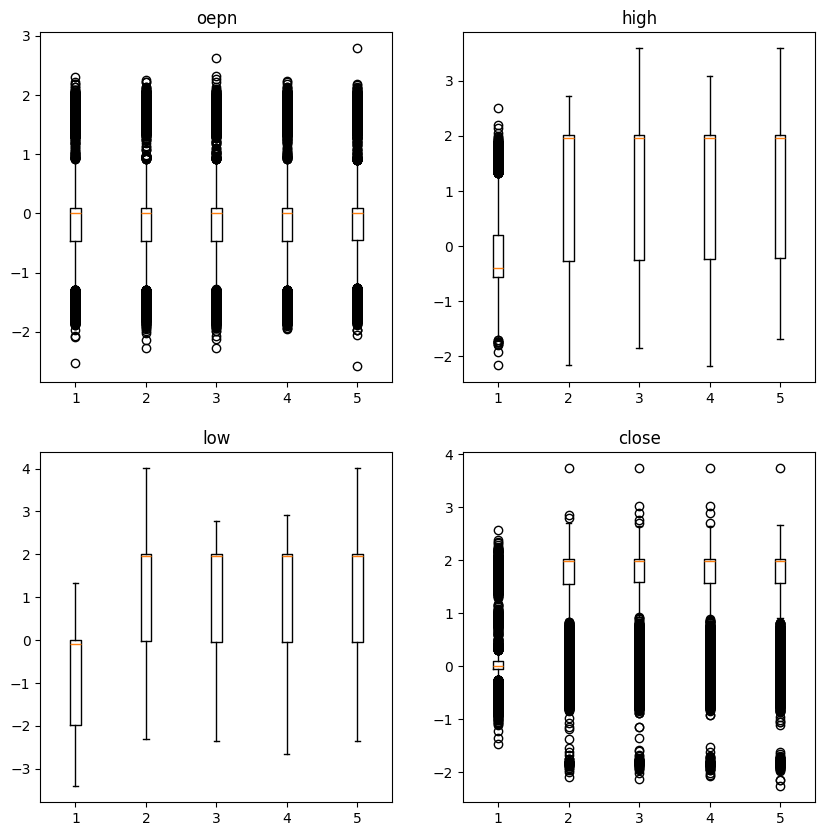

In [59]:
quant_1_org_df = pd.DataFrame(np.quantile(diff_array_org, 0.25, axis=1), columns=columns)
quant_2_org_df = pd.DataFrame(np.quantile(diff_array_org, 0.5, axis=1), columns=columns)
quant_3_org_df = pd.DataFrame(np.quantile(diff_array_org, 0.75, axis=1), columns=columns)
min_org_df = pd.DataFrame(np.min(diff_array_org, axis=1), columns=columns)
max_org_df = pd.DataFrame(np.max(diff_array_org, axis=1), columns=columns)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for index in range(0, 5):
  axs[0,0].boxplot(diff_array_org[index, :, 0], positions=[index+1])
  axs[0,1].boxplot(diff_array_org[index, :, 1], positions=[index+1])
  axs[1,0].boxplot(diff_array_org[index, :, 2], positions=[index+1])
  axs[1,1].boxplot(diff_array_org[index, :, 3], positions=[index+1])

axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')
plt.plot()

In [60]:
validation_file_path = f'{base_folder}/{model_name}/{model_name}_v{model_version}_validation.csv'
validation_df = pd.concat([
    mean_df, var_df, quant_1_df, quant_2_df, quant_3_df, min_df, max_df,
    mean_org_df, var_org_df, quant_1_org_df, quant_2_org_df, quant_3_org_df, min_org_df, max_org_df,
    ],
    keys=[
        "mean", "var", "q1", "q2", "q3", "min", "max",
        "org_mean", "org_var", "org_q1", "org_q2", "org_q3", "org_min", "org_max"
        ],
    axis=1)
os.makedirs(os.path.dirname(validation_file_path), exist_ok=True)
validation_df.to_csv(validation_file_path)
if storage_handler is not None:
    destination_file_path = f'/{model_name}/{model_name}_v{model_version}_validation.csv'
    storage_handler.upload_file(validation_file_path, destination_file_path)

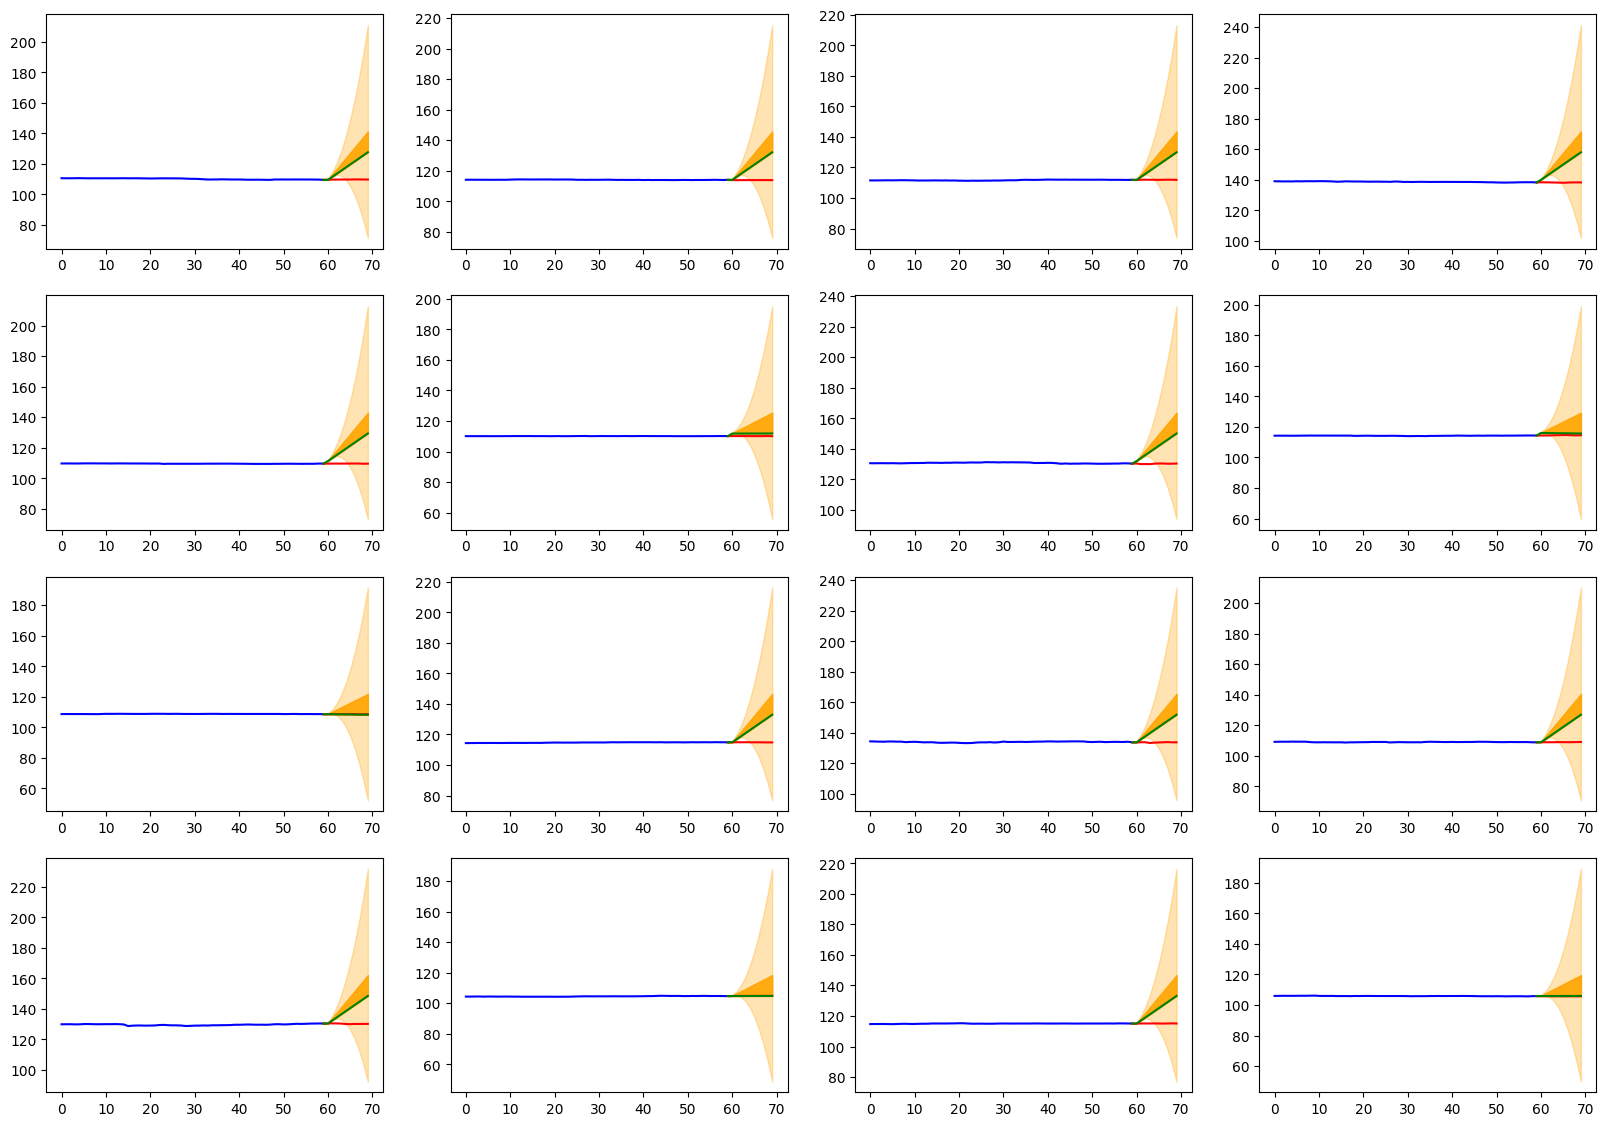

In [61]:
fig, axs = plt.subplots(4, 4, figsize=(20, 14))
close_mean = np.mean(pre_ohlc[:, :, 3]-ans_ohlc[:, :, 3], axis=1)
close_var = np.var(pre_ohlc[:, :, 3]-ans_ohlc[:, :, 3], axis=1)

total_length = observation_length + prediction_length
x = np.arange(total_length)

for i, ax in enumerate(axs.flat):
    index = ds.get_actual_index(i)
    original_ohlc = df[ohlc_column[3]].iloc[index: index + observation_length]
    pred_value = pre_ohlc[:, i, 3]
    pred_add_mean = pred_value + close_mean
    pred_upper = pred_add_mean + close_var
    pred_lower = pred_add_mean - close_var

    ax.fill_between(x[observation_length -1:], pred_value, pred_add_mean, color="orange", alpha=0.9)
    ax.fill_between(x[observation_length -1:], pred_lower, pred_upper, color="orange", alpha=0.3)
    ax.plot(x[:observation_length], original_ohlc, color="blue")
    ax.plot(x[observation_length-1:], ans_ohlc[:, i, 3], color="red")
    ax.plot(x[observation_length-1:], pred_value, color="green")
plt.show()